## For running the notebook as Google Colab Instance

In [ ]:
#mounting the google drive for accessing other necessary files
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Checking the available files in the "Colab Notebooks" folder of the google drive
!ls /content/gdrive/My\ Drive/Colab\ Notebooks

import sys

#changing the current working directory to "Colab Notebooks" folder in the google drive
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

## For running the notebook as Kaggle Kernel

change directory to the dataset where our custom scripts are uploaded

> ``os.chdir("/kaggle/input/handwritten-digit-recognition")``

***handwritten-digit-recognition*** is simply a folder name. It can vary based on the dataset you create in kaggle while uploading the python scripts.


load custom module or files or dataset

> ``from  dataset import load_dataset, train_dev_split, prep_dataset`` <br>
> ```from dataset import visualize_data_distribution, visualize_dataset```


reset our working directory

> ```os.chdir("/kaggle/working/")```

**NOTE:** The ***input directory*** is Read-Only. So, we must switch back to the ***working directory*** for performing any other operation that requires write access. Make sure this note book runs as a part of the dataset you create as said above because all the custom modules are uploaded there. 


## Importing Dependencies

In [1]:
# Python Standard Libraries for importing data from binary file
import time    #for calculating time

#core packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse

# os.chdir("/kaggle/input/handwritten-digit-recognition")

#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ffnn import init_layers, init_hyperParams
from ffnn import train, evaluate

from ModelUtils import convert_time
from ModelUtils import save_model, load_model


# # reset our working directory
# os.chdir("/kaggle/working/")


np.random.seed(1)
%matplotlib inline

In [2]:
dataset_size_in_per = 25

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")

Sample Size : 25%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (15000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (15000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (2500, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (2500, 1)


In [3]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (12750, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (12750, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (2250, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (2250, 1)


In [4]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(12750, 28, 28)		(784, 12750)
Training Set Labels:	(12750, 1)		(10, 12750)
Dev Set Images:		(2250, 28, 28)		(784, 2250)
Dev Set Labels:		(2250, 1)		(10, 2250)
Test Set Images:	(2500, 28, 28)		(784, 2500)
Test Set Labels:	(2500, 1)		(10, 2500)


## Random Search 2D

### Random Sampling

In [5]:
def sample_hyperParams(hParam_type, rng, sample_size):

    sample = []
    
    lower_range = rng[0]
    higher_range = rng[1]
    
    
    for i in range(sample_size):
        if hParam_type == "learning_rate":
            r = np.random.uniform(lower_range,higher_range)
            p = 10 ** r
            sample.append(p)
        elif hParam_type == "minibatch_size":
            s = np.random.randint(low = lower_range, high = higher_range)
            sample.append(s)
        else:
            raise ValueError("Sampling of only learning rate and minibatch size is possible for now")
            
    assert(len(sample) == sample_size)
    
    return sample



In [6]:
def calculate_new_search_space(score, samples, score_threshold = 0, summary = True):
    learning_rate = samples["learning_rate"]
    minibatch_size = samples["minibatch_size"]
    
    good_lrs = []
    good_mbs = []
    good_scs = []
    
    if score_threshold == 0:
        top_val = 10
        #if threshold = 0 use the top 10(top_val) best accuracy and their corresponding hyper parameters
        sorted_score_index = [b[0] for b in sorted(enumerate(score),key=lambda i:i[1], reverse = True)]
        good_lrs = [learning_rate[i] for i in sorted_score_index[:top_val]]
        good_mbs = [minibatch_size[i] for i in sorted_score_index[:top_val]]
        good_scs = [score[i] for i in sorted_score_index[:top_val]]
    else:
        #getting the score above the threshold and along with their corresponding hyper parameters
        for ind, val in enumerate(score):
            if val > score_threshold:
                good_lrs.append(learning_rate[ind])
                good_mbs.append(minibatch_size[ind])
                good_scs.append(val)
            
    if len(good_scs) > 1:  
        
        if summary == True:
            print("+================+===============+================+")
            print("| Validation Acc | Learning Rate | Minibatch Size |")
            print("+================+===============+================+")

            for ind,sc in enumerate(good_scs):
                print("| %.5f\t | %.5f\t | %d\t\t  |"%(sc, good_lrs[ind], good_mbs[ind]))

            print("+================+===============+================+")
        
        #calculating the new search range in log form after expanding the learning rate space by 10%
        lr_rng_new = [np.log10(0.9 * min(good_lrs) ), np.log10(1.1 * max(good_lrs))] 

        #calculating the new search range for minibatch size by expanding the search space by 5%
        mbs_rng_new = [0.85 * min(good_mbs), 1.15 * max(good_mbs)] 
        
    else:
        print("No accuracy or only one accuracy beyond threshold was obtained, so range was calculated based on the best score")
        max_lr = learning_rate[np.argmax(score)] 
        
        #calculating the new search range in log form  from the learning rate of best score, expanding by 50 % in each direction
        lr_rng_new = [np.log10(0.5 * max_lr), np.log10(1.5 * max_lr)] #calculating the range in log scale
        
        max_mbs = minibatch_size[np.argmax(score)]
        
        #calculating the new search range from the minibatch size of best score, expanding by 25 % in each direction
        mbs_rng_new = [0.75 * max_mbs, 1.25 * max_mbs] #calculaing the range
        
        
        
    #best hyper parameter combinations
    best_comb = [np.max(score),learning_rate[np.argmax(score)],minibatch_size[np.argmax(score)]]

    if summary == True:
       
        print("New Search Space for Learning Rate: [%.6f,%.6f], log range: [10e%.2f,10e%.2f]"%(10 ** lr_rng_new[0], 10 ** lr_rng_new[1], lr_rng_new[0], lr_rng_new[1]))
        print("New Search Space for Minibatch Size: [%d,%d]"%(mbs_rng_new[0], mbs_rng_new[1]))
        print("Best Score: %.6f "%(best_comb[0]))
        print("Best Hyper Params:\n Learning Rate: %.6f\n Minibatch Size: %d"%(best_comb[1], best_comb[2]))
  
    
    return lr_rng_new, mbs_rng_new, best_comb


In [7]:
def visualize_search(samples,score, lr_rng_new, mbs_rng_new, best_comb,lr_rng_old, mbs_rng_old):
    
    learning_rate = samples["learning_rate"]
    minibatch_size = samples["minibatch_size"]
    lr_min = 10 ** lr_rng_new[0]
    lr_max = 10 ** lr_rng_new[1]
    # plt.style.use('seaborn')
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))
    #setting ylim based on old range
    ylim_max = 10 ** (int(lr_rng_old[1]))
    if int(lr_rng_old[0]) == lr_rng_old[0]:
        ylim_min = 10 ** (int(lr_rng_old[0])) 
    else:
        ylim_min = 10 ** (int(lr_rng_old[0])-1) 
    
   
    ax.set_ylim(top = ylim_max, bottom = ylim_min)
    
    ax.scatter(minibatch_size,learning_rate, color = "gray",alpha=0.80)
    ax.set_yscale('log')
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    rec = Rectangle((mbs_rng_new[0], lr_min), mbs_rng_new[1] - mbs_rng_new[0], lr_max - lr_min, fill=False, edgecolor="green")
    ax.add_patch(rec)

    c = Ellipse((best_comb[2],best_comb[1]),width = 30,  height =0.30 * best_comb[1], edgecolor='green', fill = False, alpha=0.5)
    ax.add_patch(c)
    ax.scatter(best_comb[2],best_comb[1], color = "crimson",alpha=1)


    # Add labels to the plot
    style = dict(size=10, color='blue', alpha = 0.8)
    ax.text(mbs_rng_new[0], lr_max + 0.1*lr_max, "New Search Range ", ha='left', **style)
    ax.text(best_comb[2] + 25, best_comb[1] , "Best Choice ", ha='left', **style)

    
    plt.show()


In [8]:
#Coarse search with 2 epoch, fine search with 5 epoch and detailed search with 10 epoch

def random_search_2D(param1, param2, search_type ="coarse", evaluate_metric = "accuracy", sample_size = 100, search_summary = True, search_visualization = True):
    
    #accessing the input parameter types and their range
    hParam_type1 = param1["hParam type"]
    hParam_range1 = param1["hParam range"]
    
    hParam_type2 = param2["hParam type"]
    hParam_range2 = param2["hParam range"]
    
    samples = {} #for storing the generated samples
    
    #checking the search type
    if search_type == "coarse":
        epoch_size = 2
        score_threshold = 0.95
    elif search_type == "fine":
        epoch_size = 5
        score_threshold = 0.97
    elif search_type == "detail":
        epoch_size = 10
        score_threshold = 0.99
    else:
        raise ValueError("Search Type not identified. Must be 'coarse', 'fine', or 'detail'")
    
    #generating Samples for two input parameters
    samples[hParam_type1] = sample_hyperParams(hParam_type = hParam_type1, rng = hParam_range1, sample_size = sample_size)
    samples[hParam_type2] = sample_hyperParams(hParam_type = hParam_type2,rng = hParam_range2, sample_size = sample_size)
    
            
    if hParam_type1 == "learning_rate":
        leaning_rate_samples =  samples[hParam_type1]
    elif hParam_type2 == "learning_rate":
        leaning_rate_samples =  samples[hParam_type2]
    

    if hParam_type2 == "minibatch_size":
        minibatch_size_samples =  samples[hParam_type2]
    elif hParam_type1 == "minibatch_size":
        minibatch_size_samples =  samples[hParam_type2]
    
        
    score = []
    
    toc = time.time()
        
    for i in range(sample_size):
        print("\nSample: %d/%d -- Learning Rate: %.6f | Minibatch Size: %d"%(i+1,sample_size,leaning_rate_samples[i],minibatch_size_samples[i]))
        print("==========================================================================================================")
        
        hyperParams = init_hyperParams(alpha = leaning_rate_samples[i], num_epoch = epoch_size, minibatch_size = minibatch_size_samples[i], lambd = 0.7,keep_probs = [0.5,0.5])
        
        history = train(train_x_norm, train_y_encoded, dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = "dropout", verbose = 3)
        
        if evaluate_metric == "accuracy":
            val_acc = history["val_accuracy"][-1]
            score[ind1,ind2] = val_acc

        elif evaluate_metric == "f1-score": 
#                 params = history["parameters"]
#                 prediction_dev = predict(dev_x_norm, params, second_guess = False)
#                 cm_dev = confusion_matrix(dev_y_split, prediction_dev)
#                 _, macro_metrics, acc = model_metrics(cm_dev)
#                 f1_score = macro_metrics["F1-Score"]
#                 score[ind1,ind2] = f1_score
                pass

        else:
            raise ValueError("Metric must be 'accuracy' or 'f1-score'")
        
    print("==========================================================================================================")
    
    tic = time.time() # for calculating entire search time
    hrs, mins, secs , ms = convert_time((tic - toc)*1000)
    
    print("\n\n*************************** Total Search Time = %dhr %dmins %dsecs %.2fms ***************************\n\n"%(hrs, mins, secs, ms))
    
    assert(len(score) == sample_size)
    
    
    
    if search_summary == True:
        print(search_type.capitalize()+" Search Summary: \n")
    
    lr_rng_new, mbs_rng_new, best_comb = calculate_new_search_space(score, samples, score_threshold=0 , summary = search_summary)
    
    if search_visualization == True:
        visualize_search(samples,score,lr_rng_new, mbs_rng_new, best_comb,hParam_range1,hParam_range2)
    
    return lr_rng_new, mbs_rng_new, best_comb


Sample: 1/200 -- Learning Rate: 0.002494 | Minibatch Size: 828
Training The Model...

Epoch 1/2
16/16 [==================== 100%] - 2.25s 140ms/step | loss: 0.7122 | acc: 0.7892 | val_loss: 0.3433 | val_acc: 0.8987
Epoch 2/2
16/16 [==================== 100%] - 2.19s 137ms/step | loss: 0.2254 | acc: 0.9319 | val_loss: 0.2354 | val_acc: 0.9289

Total Training Time = 0hr 0mins 5secs 633.59ms

Sample: 2/200 -- Learning Rate: 0.000219 | Minibatch Size: 903
Training The Model...

Epoch 1/2
15/15 [==================== 100%] - 2.37s 158ms/step | loss: 1.5027 | acc: 0.6214 | val_loss: 0.9723 | val_acc: 0.8022
Epoch 2/2
15/15 [==================== 100%] - 2.51s 167ms/step | loss: 0.6900 | acc: 0.8426 | val_loss: 0.5469 | val_acc: 0.8618

Total Training Time = 0hr 0mins 6secs 217.37ms

Sample: 3/200 -- Learning Rate: 0.011953 | Minibatch Size: 303
Training The Model...

Epoch 1/2
43/43 [==================== 100%] - 3.94s 91ms/step | loss: 0.9902 | acc: 0.8117 | val_loss: 0.3446 | val_acc: 0.8987

/home/befrenz/Sameer Kattel/Education/Course/CSIT/7th Semester/Project Work/HandWritten-Digit-Recognition-using-Deep-Learning/9. Final Project/ModelUtils.py:121: RuntimeWarning: invalid value encountered in true_divide
  A = np.divide(t, np.sum(t, axis=0))


40/40 [==================== 100%] - 3.68s 91ms/step | loss: nan | acc: 0.4803 | val_loss: 1.2989 | val_acc: 0.5298
Epoch 2/2


/home/befrenz/Sameer Kattel/Education/Course/CSIT/7th Semester/Project Work/HandWritten-Digit-Recognition-using-Deep-Learning/9. Final Project/ModelUtils.py:86: RuntimeWarning: invalid value encountered in less_equal
  dZ[Z <= 0] = 0  # implementing integrated form of (gradiant of ReLU function * gradient of the loss function)


40/40 [==================== 100%] - 3.33s 83ms/step | loss: nan | acc: 0.2814 | val_loss: nan | val_acc: 0.1040

Total Training Time = 0hr 0mins 8secs 447.59ms

Sample: 5/200 -- Learning Rate: 0.042413 | Minibatch Size: 411
Training The Model...

Epoch 1/2
32/32 [==================== 100%] - 3.31s 103ms/step | loss: 2.4563 | acc: 0.4389 | val_loss: 1.4219 | val_acc: 0.5116
Epoch 2/2
32/32 [==================== 100%] - 3.12s 97ms/step | loss: nan | acc: 0.4519 | val_loss: nan | val_acc: 0.1040

Total Training Time = 0hr 0mins 7secs 846.90ms

Sample: 6/200 -- Learning Rate: 0.073241 | Minibatch Size: 918
Training The Model...

Epoch 1/2
14/14 [==================== 100%] - 2.41s 172ms/step | loss: nan | acc: 0.0976 | val_loss: nan | val_acc: 0.1040
Epoch 2/2
14/14 [==================== 100%] - 2.36s 168ms/step | loss: nan | acc: 0.0971 | val_loss: nan | val_acc: 0.1040

Total Training Time = 0hr 0mins 6secs 84.95ms

Sample: 7/200 -- Learning Rate: 0.058434 | Minibatch Size: 623
Training T

Training The Model...

Epoch 1/2
13/13 [==================== 100%] - 2.71s 208ms/step | loss: 2.3532 | acc: 0.6326 | val_loss: 0.6256 | val_acc: 0.8218
Epoch 2/2
13/13 [==================== 100%] - 2.56s 196ms/step | loss: 0.4189 | acc: 0.8866 | val_loss: 0.3875 | val_acc: 0.8889

Total Training Time = 0hr 0mins 6secs 829.49ms

Sample: 22/200 -- Learning Rate: 0.006720 | Minibatch Size: 242
Training The Model...

Epoch 1/2
53/53 [==================== 100%] - 4.07s 76ms/step | loss: 0.6743 | acc: 0.8390 | val_loss: 0.2583 | val_acc: 0.9182
Epoch 2/2
53/53 [==================== 100%] - 4.08s 77ms/step | loss: 0.1811 | acc: 0.9453 | val_loss: 0.2271 | val_acc: 0.9364

Total Training Time = 0hr 0mins 9secs 641.09ms

Sample: 23/200 -- Learning Rate: 0.010404 | Minibatch Size: 265
Training The Model...

Epoch 1/2
49/49 [==================== 100%] - 4.09s 83ms/step | loss: 0.8320 | acc: 0.8304 | val_loss: 0.3239 | val_acc: 0.9080
Epoch 2/2
49/49 [==================== 100%] - 4.12s 84ms/step |

Training The Model...

Epoch 1/2
108/108 [==================== 100%] - 6.19s 57ms/step | loss: 0.3463 | acc: 0.8958 | val_loss: 0.2285 | val_acc: 0.9356
Epoch 2/2
108/108 [==================== 100%] - 6.31s 58ms/step | loss: 0.1405 | acc: 0.9604 | val_loss: 0.1953 | val_acc: 0.9418

Total Training Time = 0hr 0mins 14secs 162.01ms

Sample: 55/200 -- Learning Rate: 0.005335 | Minibatch Size: 77
Training The Model...

Epoch 1/2
166/166 [==================== 100%] - 8.75s 52ms/step | loss: 0.3532 | acc: 0.8998 | val_loss: 0.2666 | val_acc: 0.9227
Epoch 2/2
166/166 [==================== 100%] - 8.40s 50ms/step | loss: 0.1758 | acc: 0.9503 | val_loss: 0.2355 | val_acc: 0.9298

Total Training Time = 0hr 0mins 18secs 901.05ms

Sample: 56/200 -- Learning Rate: 0.013478 | Minibatch Size: 828
Training The Model...

Epoch 1/2
16/16 [==================== 100%] - 2.67s 166ms/step | loss: 1.8890 | acc: 0.6577 | val_loss: 0.5646 | val_acc: 0.8507
Epoch 2/2
16/16 [==================== 100%] - 2.63s 164

120/120 [==================== 100%] - 6.91s 57ms/step | loss: nan | acc: 0.0976 | val_loss: nan | val_acc: 0.1040
Epoch 2/2
120/120 [==================== 100%] - 7.04s 58ms/step | loss: nan | acc: 0.0977 | val_loss: nan | val_acc: 0.1040

Total Training Time = 0hr 0mins 15secs 545.38ms

Sample: 88/200 -- Learning Rate: 0.030284 | Minibatch Size: 161
Training The Model...

Epoch 1/2
80/80 [==================== 100%] - 5.01s 62ms/step | loss: 1.2832 | acc: 0.7044 | val_loss: 0.9920 | val_acc: 0.7027
Epoch 2/2
80/80 [==================== 100%] - 5.59s 69ms/step | loss: 0.9150 | acc: 0.7179 | val_loss: 1.2021 | val_acc: 0.7169

Total Training Time = 0hr 0mins 12secs 146.01ms

Sample: 89/200 -- Learning Rate: 0.002883 | Minibatch Size: 176
Training The Model...

Epoch 1/2
73/73 [==================== 100%] - 5.52s 75ms/step | loss: 0.3932 | acc: 0.8857 | val_loss: 0.2266 | val_acc: 0.9364
Epoch 2/2
73/73 [==================== 100%] - 5.88s 80ms/step | loss: 0.1427 | acc: 0.9567 | val_loss: 0


Sample: 120/200 -- Learning Rate: 0.019380 | Minibatch Size: 877
Training The Model...

Epoch 1/2
15/15 [==================== 100%] - 3.05s 203ms/step | loss: 2.3063 | acc: 0.6467 | val_loss: 0.6335 | val_acc: 0.8124
Epoch 2/2
15/15 [==================== 100%] - 2.99s 199ms/step | loss: 0.4190 | acc: 0.8793 | val_loss: 0.4018 | val_acc: 0.8796

Total Training Time = 0hr 0mins 7secs 632.93ms

Sample: 121/200 -- Learning Rate: 0.000664 | Minibatch Size: 880
Training The Model...

Epoch 1/2
15/15 [==================== 100%] - 3.09s 205ms/step | loss: 0.8908 | acc: 0.7692 | val_loss: 0.4462 | val_acc: 0.8707
Epoch 2/2
15/15 [==================== 100%] - 3.08s 205ms/step | loss: 0.3361 | acc: 0.9012 | val_loss: 0.3221 | val_acc: 0.9093

Total Training Time = 0hr 0mins 7secs 911.34ms

Sample: 122/200 -- Learning Rate: 0.002189 | Minibatch Size: 858
Training The Model...

Epoch 1/2
15/15 [==================== 100%] - 3.14s 209ms/step | loss: 0.7252 | acc: 0.7759 | val_loss: 0.3696 | val_acc:

24/24 [==================== 100%] - 3.51s 146ms/step | loss: 0.5924 | acc: 0.8283 | val_loss: 0.3265 | val_acc: 0.9053
Epoch 2/2
24/24 [==================== 100%] - 3.74s 155ms/step | loss: 0.2290 | acc: 0.9333 | val_loss: 0.2344 | val_acc: 0.9342

Total Training Time = 0hr 0mins 9secs 27.84ms

Sample: 137/200 -- Learning Rate: 0.008479 | Minibatch Size: 364
Training The Model...

Epoch 1/2
36/36 [==================== 100%] - 3.94s 109ms/step | loss: 0.8341 | acc: 0.8107 | val_loss: 0.2965 | val_acc: 0.9187
Epoch 2/2
36/36 [==================== 100%] - 3.87s 107ms/step | loss: 0.1963 | acc: 0.9423 | val_loss: 0.2834 | val_acc: 0.9138

Total Training Time = 0hr 0mins 9secs 410.33ms

Sample: 138/200 -- Learning Rate: 0.031320 | Minibatch Size: 338
Training The Model...

Epoch 1/2
38/38 [==================== 100%] - 4.07s 106ms/step | loss: 1.7399 | acc: 0.6930 | val_loss: 0.7000 | val_acc: 0.8173
Epoch 2/2
38/38 [==================== 100%] - 4.02s 105ms/step | loss: 0.6171 | acc: 0.8449 

Training The Model...

Epoch 1/2
47/47 [==================== 100%] - 4.42s 93ms/step | loss: 0.9431 | acc: 0.7645 | val_loss: 0.4548 | val_acc: 0.8809
Epoch 2/2
47/47 [==================== 100%] - 4.31s 91ms/step | loss: 0.3489 | acc: 0.9009 | val_loss: 0.3281 | val_acc: 0.9071

Total Training Time = 0hr 0mins 10secs 586.18ms

Sample: 170/200 -- Learning Rate: 0.016550 | Minibatch Size: 156
Training The Model...

Epoch 1/2
82/82 [==================== 100%] - 5.81s 70ms/step | loss: 0.7941 | acc: 0.8375 | val_loss: 0.4659 | val_acc: 0.8729
Epoch 2/2
82/82 [==================== 100%] - 5.87s 71ms/step | loss: 0.3585 | acc: 0.9064 | val_loss: 0.4473 | val_acc: 0.8818

Total Training Time = 0hr 0mins 13secs 347.75ms

Sample: 171/200 -- Learning Rate: 0.000117 | Minibatch Size: 320
Training The Model...

Epoch 1/2
40/40 [==================== 100%] - 4.49s 112ms/step | loss: 1.4473 | acc: 0.6495 | val_loss: 0.8826 | val_acc: 0.8156
Epoch 2/2
40/40 [==================== 100%] - 4.50s 112ms/st

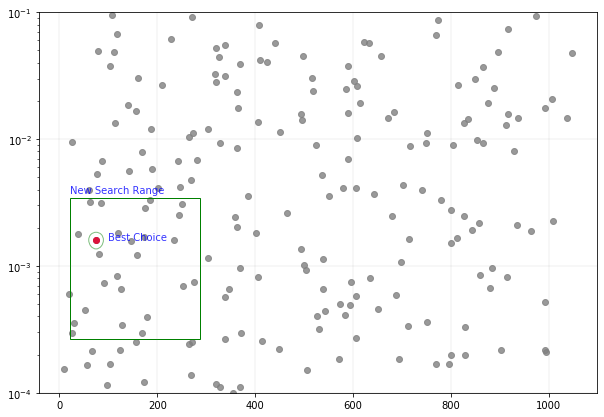

In [10]:
#use larger network with more hidden layers(<=5) and hidden units for better result.
#Note: Larger Network will take more time to tune though the greaning is optimized to greater extend
layers_dim = init_layers(784, 10, hidden_layers = [1024,1024])

#Coarse Random Search
lr_rng_coarse = [-5,-1]
mbs_rng_coarse = [10,1000]

param1_coarse = {"hParam type": "learning_rate" ,
          "hParam range": lr_rng_coarse }
    
param2_coarse = {"hParam type": "minibatch_size",
          "hParam range": mbs_rng_coarse } 

#use sample_size >=200 for better tuning
lr_rng_fine, mbs_rng_fine, best_comb = random_search_2D(param1 = param1_coarse, param2 = param2_coarse , search_type ="coarse", evaluate_metric = "accuracy", sample_size = 200, search_summary = True, search_visualization = True)



Sample: 1/100 -- Learning Rate: 0.000874 | Minibatch Size: 136
Training The Model...

Epoch 1/5
94/94 [==================== 100%] - 5.26s 55ms/step | loss: 0.4193 | acc: 0.8827 | val_loss: 0.2649 | val_acc: 0.9227
Epoch 2/5
94/94 [==================== 100%] - 5.62s 59ms/step | loss: 0.1766 | acc: 0.9491 | val_loss: 0.2024 | val_acc: 0.9431
Epoch 3/5
94/94 [==================== 100%] - 5.71s 60ms/step | loss: 0.1199 | acc: 0.9651 | val_loss: 0.1739 | val_acc: 0.9489
Epoch 4/5
94/94 [==================== 100%] - 5.97s 63ms/step | loss: 0.0857 | acc: 0.9763 | val_loss: 0.1602 | val_acc: 0.9551
Epoch 5/5
94/94 [==================== 100%] - 5.74s 61ms/step | loss: 0.0677 | acc: 0.9810 | val_loss: 0.1498 | val_acc: 0.9556

Total Training Time = 0hr 0mins 32secs 365.20ms

Sample: 2/100 -- Learning Rate: 0.000356 | Minibatch Size: 151
Training The Model...

Epoch 1/5
85/85 [==================== 100%] - 6.19s 72ms/step | loss: 0.6518 | acc: 0.8286 | val_loss: 0.3599 | val_acc: 0.8947
Epoch 2/5

46/46 [==================== 100%] - 4.40s 95ms/step | loss: 0.1442 | acc: 0.9583 | val_loss: 0.1854 | val_acc: 0.9462
Epoch 4/5
46/46 [==================== 100%] - 4.26s 92ms/step | loss: 0.1060 | acc: 0.9702 | val_loss: 0.1676 | val_acc: 0.9511
Epoch 5/5
46/46 [==================== 100%] - 4.30s 93ms/step | loss: 0.0810 | acc: 0.9774 | val_loss: 0.1523 | val_acc: 0.9547

Total Training Time = 0hr 0mins 26secs 275.30ms

Sample: 20/100 -- Learning Rate: 0.002784 | Minibatch Size: 168
Training The Model...

Epoch 1/5
76/76 [==================== 100%] - 5.38s 70ms/step | loss: 0.3236 | acc: 0.9027 | val_loss: 0.2203 | val_acc: 0.9342
Epoch 2/5
76/76 [==================== 100%] - 5.44s 71ms/step | loss: 0.1385 | acc: 0.9590 | val_loss: 0.1753 | val_acc: 0.9489
Epoch 3/5
76/76 [==================== 100%] - 5.30s 69ms/step | loss: 0.1000 | acc: 0.9701 | val_loss: 0.1616 | val_acc: 0.9533
Epoch 4/5
76/76 [==================== 100%] - 5.35s 70ms/step | loss: 0.0739 | acc: 0.9788 | val_loss: 0.

47/47 [==================== 100%] - 4.31s 91ms/step | loss: 0.0974 | acc: 0.9730 | val_loss: 0.1601 | val_acc: 0.9489

Total Training Time = 0hr 0mins 26secs 211.67ms

Sample: 29/100 -- Learning Rate: 0.000414 | Minibatch Size: 137
Training The Model...

Epoch 1/5
94/94 [==================== 100%] - 6.39s 68ms/step | loss: 0.5959 | acc: 0.8365 | val_loss: 0.3328 | val_acc: 0.9036
Epoch 2/5
94/94 [==================== 100%] - 6.40s 68ms/step | loss: 0.2415 | acc: 0.9310 | val_loss: 0.2507 | val_acc: 0.9329
Epoch 3/5
94/94 [==================== 100%] - 6.53s 69ms/step | loss: 0.1719 | acc: 0.9507 | val_loss: 0.2092 | val_acc: 0.9360
Epoch 4/5
94/94 [==================== 100%] - 6.79s 72ms/step | loss: 0.1336 | acc: 0.9610 | val_loss: 0.1805 | val_acc: 0.9489
Epoch 5/5
94/94 [==================== 100%] - 6.33s 67ms/step | loss: 0.1079 | acc: 0.9688 | val_loss: 0.1702 | val_acc: 0.9462

Total Training Time = 0hr 0mins 37secs 189.49ms

Sample: 30/100 -- Learning Rate: 0.000587 | Minibatch S

Training The Model...

Epoch 1/5
213/213 [==================== 100%] - 11.45s 53ms/step | loss: 0.3053 | acc: 0.9123 | val_loss: 0.2233 | val_acc: 0.9293
Epoch 2/5
213/213 [==================== 100%] - 11.13s 52ms/step | loss: 0.1406 | acc: 0.9579 | val_loss: 0.2111 | val_acc: 0.9409
Epoch 3/5
213/213 [==================== 100%] - 11.27s 52ms/step | loss: 0.1067 | acc: 0.9674 | val_loss: 0.2015 | val_acc: 0.9400
Epoch 4/5
213/213 [==================== 100%] - 11.45s 53ms/step | loss: 0.0791 | acc: 0.9767 | val_loss: 0.1587 | val_acc: 0.9533
Epoch 5/5
213/213 [==================== 100%] - 11.79s 55ms/step | loss: 0.0692 | acc: 0.9800 | val_loss: 0.1694 | val_acc: 0.9533

Total Training Time = 0hr 1mins 2secs 192.04ms

Sample: 39/100 -- Learning Rate: 0.000323 | Minibatch Size: 121
Training The Model...

Epoch 1/5
106/106 [==================== 100%] - 6.63s 62ms/step | loss: 0.6412 | acc: 0.8281 | val_loss: 0.3506 | val_acc: 0.9000
Epoch 2/5
106/106 [==================== 100%] - 6.73s 63

53/53 [==================== 100%] - 4.58s 86ms/step | loss: 0.1054 | acc: 0.9684 | val_loss: 0.1671 | val_acc: 0.9498
Epoch 4/5
53/53 [==================== 100%] - 4.53s 85ms/step | loss: 0.0743 | acc: 0.9795 | val_loss: 0.1508 | val_acc: 0.9560
Epoch 5/5
53/53 [==================== 100%] - 4.59s 86ms/step | loss: 0.0566 | acc: 0.9839 | val_loss: 0.1517 | val_acc: 0.9538

Total Training Time = 0hr 0mins 27secs 271.13ms

Sample: 57/100 -- Learning Rate: 0.000776 | Minibatch Size: 108
Training The Model...

Epoch 1/5
119/119 [==================== 100%] - 7.55s 63ms/step | loss: 0.4249 | acc: 0.8850 | val_loss: 0.2662 | val_acc: 0.9187
Epoch 2/5
119/119 [==================== 100%] - 7.30s 61ms/step | loss: 0.1758 | acc: 0.9497 | val_loss: 0.2009 | val_acc: 0.9427
Epoch 3/5
119/119 [==================== 100%] - 7.30s 61ms/step | loss: 0.1209 | acc: 0.9654 | val_loss: 0.1730 | val_acc: 0.9484
Epoch 4/5
119/119 [==================== 100%] - 7.37s 61ms/step | loss: 0.0836 | acc: 0.9754 | val_

Training The Model...

Epoch 1/5
46/46 [==================== 100%] - 4.21s 91ms/step | loss: 0.5146 | acc: 0.8540 | val_loss: 0.3180 | val_acc: 0.9044
Epoch 2/5
46/46 [==================== 100%] - 4.21s 91ms/step | loss: 0.2141 | acc: 0.9381 | val_loss: 0.2396 | val_acc: 0.9311
Epoch 3/5
46/46 [==================== 100%] - 4.33s 94ms/step | loss: 0.1494 | acc: 0.9574 | val_loss: 0.1917 | val_acc: 0.9431
Epoch 4/5
46/46 [==================== 100%] - 4.17s 90ms/step | loss: 0.1102 | acc: 0.9689 | val_loss: 0.1723 | val_acc: 0.9520
Epoch 5/5
46/46 [==================== 100%] - 4.32s 93ms/step | loss: 0.0863 | acc: 0.9756 | val_loss: 0.1535 | val_acc: 0.9556

Total Training Time = 0hr 0mins 25secs 747.41ms

Sample: 76/100 -- Learning Rate: 0.000534 | Minibatch Size: 61
Training The Model...

Epoch 1/5
210/210 [==================== 100%] - 10.80s 51ms/step | loss: 0.4322 | acc: 0.8816 | val_loss: 0.2779 | val_acc: 0.9164
Epoch 2/5
210/210 [==================== 100%] - 10.77s 51ms/step | los

92/92 [==================== 100%] - 6.80s 73ms/step | loss: 0.1265 | acc: 0.9635 | val_loss: 0.1771 | val_acc: 0.9484
Epoch 4/5
92/92 [==================== 100%] - 6.63s 72ms/step | loss: 0.0897 | acc: 0.9752 | val_loss: 0.1559 | val_acc: 0.9538
Epoch 5/5
92/92 [==================== 100%] - 7.50s 81ms/step | loss: 0.0682 | acc: 0.9812 | val_loss: 0.1473 | val_acc: 0.9569

Total Training Time = 0hr 0mins 40secs 53.83ms

Sample: 94/100 -- Learning Rate: 0.000300 | Minibatch Size: 46
Training The Model...

Epoch 1/5
278/278 [==================== 100%] - 14.53s 52ms/step | loss: 0.5133 | acc: 0.8579 | val_loss: 0.3071 | val_acc: 0.9080
Epoch 2/5
278/278 [==================== 100%] - 13.38s 48ms/step | loss: 0.2065 | acc: 0.9404 | val_loss: 0.2214 | val_acc: 0.9382
Epoch 3/5
278/278 [==================== 100%] - 13.26s 47ms/step | loss: 0.1509 | acc: 0.9564 | val_loss: 0.1916 | val_acc: 0.9467
Epoch 4/5
278/278 [==================== 100%] - 13.70s 49ms/step | loss: 0.1146 | acc: 0.9679 | va

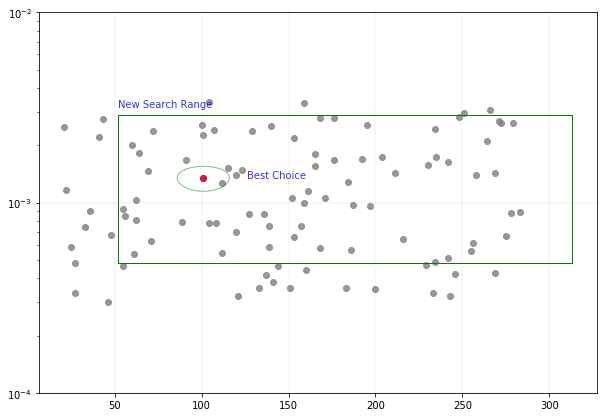

In [11]:
#Fine Random Search

param1_fine = {"hParam type": "learning_rate" ,
          "hParam range": lr_rng_fine }
    
param2_fine = {"hParam type": "minibatch_size",
          "hParam range": mbs_rng_fine } 

#use sample_size >= 200 for better tuning

lr_rng_detail, mbs_rng_detail, best_comb = random_search_2D(param1 = param1_fine, param2 = param2_fine , search_type ="fine", evaluate_metric = "accuracy", sample_size = 100, search_summary = True, search_visualization = True)



Sample: 1/100 -- Learning Rate: 0.001187 | Minibatch Size: 169
Training The Model...

Epoch 1/10
76/76 [==================== 100%] - 5.84s 76ms/step | loss: 0.4055 | acc: 0.8868 | val_loss: 0.2550 | val_acc: 0.9258
Epoch 2/10
76/76 [==================== 100%] - 4.91s 64ms/step | loss: 0.1660 | acc: 0.9512 | val_loss: 0.1988 | val_acc: 0.9427
Epoch 3/10
76/76 [==================== 100%] - 5.26s 69ms/step | loss: 0.1098 | acc: 0.9691 | val_loss: 0.1714 | val_acc: 0.9444
Epoch 4/10
76/76 [==================== 100%] - 5.31s 69ms/step | loss: 0.0782 | acc: 0.9771 | val_loss: 0.1709 | val_acc: 0.9542
Epoch 5/10
76/76 [==================== 100%] - 5.50s 72ms/step | loss: 0.0616 | acc: 0.9826 | val_loss: 0.1427 | val_acc: 0.9564
Epoch 6/10
76/76 [==================== 100%] - 5.57s 73ms/step | loss: 0.0469 | acc: 0.9866 | val_loss: 0.1429 | val_acc: 0.9596
Epoch 7/10
76/76 [==================== 100%] - 5.89s 77ms/step | loss: 0.0332 | acc: 0.9899 | val_loss: 0.1500 | val_acc: 0.9573
Epoch 8/10

149/149 [==================== 100%] - 9.87s 66ms/step | loss: 0.1176 | acc: 0.9674 | val_loss: 0.1874 | val_acc: 0.9436
Epoch 4/10
149/149 [==================== 100%] - 9.94s 66ms/step | loss: 0.0860 | acc: 0.9742 | val_loss: 0.1496 | val_acc: 0.9578
Epoch 5/10
149/149 [==================== 100%] - 8.77s 58ms/step | loss: 0.0613 | acc: 0.9835 | val_loss: 0.1464 | val_acc: 0.9591
Epoch 6/10
149/149 [==================== 100%] - 8.48s 56ms/step | loss: 0.0466 | acc: 0.9873 | val_loss: 0.1446 | val_acc: 0.9604
Epoch 7/10
149/149 [==================== 100%] - 8.62s 57ms/step | loss: 0.0372 | acc: 0.9896 | val_loss: 0.1430 | val_acc: 0.9604
Epoch 8/10
149/149 [==================== 100%] - 8.56s 57ms/step | loss: 0.0293 | acc: 0.9923 | val_loss: 0.1508 | val_acc: 0.9613
Epoch 9/10
149/149 [==================== 100%] - 8.68s 58ms/step | loss: 0.0245 | acc: 0.9930 | val_loss: 0.1491 | val_acc: 0.9613
Epoch 10/10
149/149 [==================== 100%] - 8.53s 57ms/step | loss: 0.0201 | acc: 0.9946

122/122 [==================== 100%] - 7.92s 64ms/step | loss: 0.0168 | acc: 0.9959 | val_loss: 0.1504 | val_acc: 0.9622

Total Training Time = 0hr 1mins 22secs 924.39ms

Sample: 17/100 -- Learning Rate: 0.001863 | Minibatch Size: 117
Training The Model...

Epoch 1/10
109/109 [==================== 100%] - 7.34s 67ms/step | loss: 0.3266 | acc: 0.9048 | val_loss: 0.2241 | val_acc: 0.9351
Epoch 2/10
109/109 [==================== 100%] - 7.48s 68ms/step | loss: 0.1371 | acc: 0.9612 | val_loss: 0.1818 | val_acc: 0.9467
Epoch 3/10
109/109 [==================== 100%] - 7.16s 65ms/step | loss: 0.0949 | acc: 0.9727 | val_loss: 0.1652 | val_acc: 0.9547
Epoch 4/10
109/109 [==================== 100%] - 7.46s 68ms/step | loss: 0.0704 | acc: 0.9801 | val_loss: 0.1629 | val_acc: 0.9547
Epoch 5/10
109/109 [==================== 100%] - 7.18s 65ms/step | loss: 0.0613 | acc: 0.9831 | val_loss: 0.1606 | val_acc: 0.9551
Epoch 6/10
109/109 [==================== 100%] - 7.49s 68ms/step | loss: 0.0470 | acc: 0

139/139 [==================== 100%] - 10.28s 73ms/step | loss: 0.1860 | acc: 0.9462 | val_loss: 0.2001 | val_acc: 0.9396
Epoch 3/10
139/139 [==================== 100%] - 9.77s 70ms/step | loss: 0.1277 | acc: 0.9629 | val_loss: 0.1718 | val_acc: 0.9520
Epoch 4/10
139/139 [==================== 100%] - 9.28s 66ms/step | loss: 0.0922 | acc: 0.9724 | val_loss: 0.1573 | val_acc: 0.9551
Epoch 5/10
139/139 [==================== 100%] - 9.49s 68ms/step | loss: 0.0707 | acc: 0.9807 | val_loss: 0.1503 | val_acc: 0.9560
Epoch 6/10
139/139 [==================== 100%] - 9.39s 67ms/step | loss: 0.0535 | acc: 0.9858 | val_loss: 0.1429 | val_acc: 0.9578
Epoch 7/10
139/139 [==================== 100%] - 10.05s 72ms/step | loss: 0.0404 | acc: 0.9888 | val_loss: 0.1399 | val_acc: 0.9569
Epoch 8/10
139/139 [==================== 100%] - 9.51s 68ms/step | loss: 0.0302 | acc: 0.9921 | val_loss: 0.1444 | val_acc: 0.9640
Epoch 9/10
139/139 [==================== 100%] - 9.71s 69ms/step | loss: 0.0247 | acc: 0.992

46/46 [==================== 100%] - 4.12s 89ms/step | loss: 0.0417 | acc: 0.9881 | val_loss: 0.1657 | val_acc: 0.9538
Epoch 7/10
46/46 [==================== 100%] - 4.17s 90ms/step | loss: 0.0377 | acc: 0.9894 | val_loss: 0.1460 | val_acc: 0.9533
Epoch 8/10
46/46 [==================== 100%] - 4.12s 89ms/step | loss: 0.0332 | acc: 0.9896 | val_loss: 0.1686 | val_acc: 0.9542
Epoch 9/10
46/46 [==================== 100%] - 4.13s 89ms/step | loss: 0.0308 | acc: 0.9913 | val_loss: 0.1542 | val_acc: 0.9627
Epoch 10/10
46/46 [==================== 100%] - 4.13s 89ms/step | loss: 0.0205 | acc: 0.9931 | val_loss: 0.1416 | val_acc: 0.9609

Total Training Time = 0hr 0mins 51secs 129.44ms

Sample: 28/100 -- Learning Rate: 0.000566 | Minibatch Size: 311
Training The Model...

Epoch 1/10
41/41 [==================== 100%] - 4.05s 98ms/step | loss: 0.6354 | acc: 0.8289 | val_loss: 0.3425 | val_acc: 0.8987
Epoch 2/10
41/41 [==================== 100%] - 4.03s 98ms/step | loss: 0.2525 | acc: 0.9264 | val_l

237/237 [==================== 100%] - 11.73s 49ms/step | loss: 0.0197 | acc: 0.9947 | val_loss: 0.1512 | val_acc: 0.9618

Total Training Time = 0hr 2mins 17secs 480.49ms

Sample: 33/100 -- Learning Rate: 0.001288 | Minibatch Size: 271
Training The Model...

Epoch 1/10
48/48 [==================== 100%] - 4.56s 94ms/step | loss: 0.4407 | acc: 0.8746 | val_loss: 0.2699 | val_acc: 0.9222
Epoch 2/10
48/48 [==================== 100%] - 4.38s 91ms/step | loss: 0.1803 | acc: 0.9454 | val_loss: 0.2041 | val_acc: 0.9422
Epoch 3/10
48/48 [==================== 100%] - 4.53s 94ms/step | loss: 0.1198 | acc: 0.9656 | val_loss: 0.1801 | val_acc: 0.9444
Epoch 4/10
48/48 [==================== 100%] - 4.65s 96ms/step | loss: 0.0897 | acc: 0.9743 | val_loss: 0.1602 | val_acc: 0.9516
Epoch 5/10
48/48 [==================== 100%] - 4.36s 90ms/step | loss: 0.0706 | acc: 0.9802 | val_loss: 0.1477 | val_acc: 0.9587
Epoch 6/10
48/48 [==================== 100%] - 4.28s 89ms/step | loss: 0.0472 | acc: 0.9869 | val

60/60 [==================== 100%] - 4.89s 81ms/step | loss: 0.2444 | acc: 0.9294 | val_loss: 0.2570 | val_acc: 0.9284
Epoch 3/10
60/60 [==================== 100%] - 5.00s 83ms/step | loss: 0.1780 | acc: 0.9483 | val_loss: 0.2169 | val_acc: 0.9387
Epoch 4/10
60/60 [==================== 100%] - 4.92s 82ms/step | loss: 0.1385 | acc: 0.9590 | val_loss: 0.1843 | val_acc: 0.9453
Epoch 5/10
60/60 [==================== 100%] - 4.78s 79ms/step | loss: 0.1099 | acc: 0.9675 | val_loss: 0.1670 | val_acc: 0.9498
Epoch 6/10
60/60 [==================== 100%] - 4.82s 80ms/step | loss: 0.0889 | acc: 0.9752 | val_loss: 0.1594 | val_acc: 0.9533
Epoch 7/10
60/60 [==================== 100%] - 4.85s 80ms/step | loss: 0.0723 | acc: 0.9815 | val_loss: 0.1469 | val_acc: 0.9556
Epoch 8/10
60/60 [==================== 100%] - 4.83s 80ms/step | loss: 0.0576 | acc: 0.9861 | val_loss: 0.1503 | val_acc: 0.9551
Epoch 9/10
60/60 [==================== 100%] - 4.93s 82ms/step | loss: 0.0479 | acc: 0.9878 | val_loss: 0.14

121/121 [==================== 100%] - 6.56s 54ms/step | loss: 0.0494 | acc: 0.9859 | val_loss: 0.1440 | val_acc: 0.9609
Epoch 7/10
121/121 [==================== 100%] - 6.41s 52ms/step | loss: 0.0429 | acc: 0.9875 | val_loss: 0.1515 | val_acc: 0.9600
Epoch 8/10
121/121 [==================== 100%] - 6.48s 53ms/step | loss: 0.0382 | acc: 0.9889 | val_loss: 0.1508 | val_acc: 0.9578
Epoch 9/10
121/121 [==================== 100%] - 6.43s 53ms/step | loss: 0.0341 | acc: 0.9890 | val_loss: 0.1528 | val_acc: 0.9604
Epoch 10/10
121/121 [==================== 100%] - 6.57s 54ms/step | loss: 0.0300 | acc: 0.9912 | val_loss: 0.1538 | val_acc: 0.9604

Total Training Time = 0hr 1mins 14secs 61.33ms

Sample: 44/100 -- Learning Rate: 0.002389 | Minibatch Size: 201
Training The Model...

Epoch 1/10
64/64 [==================== 100%] - 4.71s 73ms/step | loss: 0.3715 | acc: 0.8878 | val_loss: 0.2206 | val_acc: 0.9373
Epoch 2/10
64/64 [==================== 100%] - 4.83s 75ms/step | loss: 0.1443 | acc: 0.958

53/53 [==================== 100%] - 4.18s 78ms/step | loss: 0.0186 | acc: 0.9951 | val_loss: 0.1423 | val_acc: 0.9600

Total Training Time = 0hr 0mins 50secs 2.65ms

Sample: 49/100 -- Learning Rate: 0.002078 | Minibatch Size: 141
Training The Model...

Epoch 1/10
91/91 [==================== 100%] - 5.44s 59ms/step | loss: 0.3413 | acc: 0.9008 | val_loss: 0.2192 | val_acc: 0.9360
Epoch 2/10
91/91 [==================== 100%] - 5.42s 59ms/step | loss: 0.1403 | acc: 0.9573 | val_loss: 0.1891 | val_acc: 0.9458
Epoch 3/10
91/91 [==================== 100%] - 5.45s 59ms/step | loss: 0.0958 | acc: 0.9734 | val_loss: 0.1657 | val_acc: 0.9556
Epoch 4/10
91/91 [==================== 100%] - 5.44s 59ms/step | loss: 0.0707 | acc: 0.9793 | val_loss: 0.1689 | val_acc: 0.9551
Epoch 5/10
91/91 [==================== 100%] - 5.40s 59ms/step | loss: 0.0580 | acc: 0.9827 | val_loss: 0.1622 | val_acc: 0.9480
Epoch 6/10
91/91 [==================== 100%] - 5.47s 60ms/step | loss: 0.0459 | acc: 0.9862 | val_loss

210/210 [==================== 100%] - 12.13s 57ms/step | loss: 0.1403 | acc: 0.9578 | val_loss: 0.1789 | val_acc: 0.9444
Epoch 3/10
210/210 [==================== 100%] - 12.19s 58ms/step | loss: 0.1010 | acc: 0.9704 | val_loss: 0.2005 | val_acc: 0.9493
Epoch 4/10
210/210 [==================== 100%] - 12.54s 59ms/step | loss: 0.0839 | acc: 0.9744 | val_loss: 0.1789 | val_acc: 0.9493
Epoch 5/10
210/210 [==================== 100%] - 12.15s 57ms/step | loss: 0.0736 | acc: 0.9775 | val_loss: 0.1973 | val_acc: 0.9458
Epoch 6/10
210/210 [==================== 100%] - 12.48s 59ms/step | loss: 0.0635 | acc: 0.9814 | val_loss: 0.1802 | val_acc: 0.9507
Epoch 7/10
210/210 [==================== 100%] - 12.41s 59ms/step | loss: 0.0541 | acc: 0.9842 | val_loss: 0.1700 | val_acc: 0.9551
Epoch 8/10
210/210 [==================== 100%] - 12.09s 57ms/step | loss: 0.0587 | acc: 0.9826 | val_loss: 0.1548 | val_acc: 0.9560
Epoch 9/10
210/210 [==================== 100%] - 12.41s 59ms/step | loss: 0.0473 | acc:

55/55 [==================== 100%] - 4.49s 81ms/step | loss: 0.0457 | acc: 0.9885 | val_loss: 0.1483 | val_acc: 0.9542
Epoch 9/10
55/55 [==================== 100%] - 4.35s 79ms/step | loss: 0.0342 | acc: 0.9913 | val_loss: 0.1388 | val_acc: 0.9604
Epoch 10/10
55/55 [==================== 100%] - 4.52s 82ms/step | loss: 0.0279 | acc: 0.9927 | val_loss: 0.1443 | val_acc: 0.9618

Total Training Time = 0hr 0mins 56secs 967.32ms

Sample: 65/100 -- Learning Rate: 0.000547 | Minibatch Size: 164
Training The Model...

Epoch 1/10
78/78 [==================== 100%] - 5.64s 72ms/step | loss: 0.5280 | acc: 0.8596 | val_loss: 0.2938 | val_acc: 0.9160
Epoch 2/10
78/78 [==================== 100%] - 5.46s 69ms/step | loss: 0.2169 | acc: 0.9376 | val_loss: 0.2323 | val_acc: 0.9364
Epoch 3/10
78/78 [==================== 100%] - 6.74s 86ms/step | loss: 0.1536 | acc: 0.9543 | val_loss: 0.1949 | val_acc: 0.9413
Epoch 4/10
78/78 [==================== 100%] - 7.87s 100ms/step | loss: 0.1131 | acc: 0.9675 | val_

70/70 [==================== 100%] - 5.49s 78ms/step | loss: 0.3697 | acc: 0.8899 | val_loss: 0.2184 | val_acc: 0.9360
Epoch 2/10
70/70 [==================== 100%] - 5.93s 84ms/step | loss: 0.1430 | acc: 0.9568 | val_loss: 0.1793 | val_acc: 0.9480
Epoch 3/10
70/70 [==================== 100%] - 5.92s 84ms/step | loss: 0.0958 | acc: 0.9708 | val_loss: 0.1465 | val_acc: 0.9529
Epoch 4/10
70/70 [==================== 100%] - 5.57s 79ms/step | loss: 0.0708 | acc: 0.9813 | val_loss: 0.1427 | val_acc: 0.9582
Epoch 5/10
70/70 [==================== 100%] - 5.45s 77ms/step | loss: 0.0534 | acc: 0.9840 | val_loss: 0.1554 | val_acc: 0.9556
Epoch 6/10
70/70 [==================== 100%] - 5.54s 79ms/step | loss: 0.0447 | acc: 0.9870 | val_loss: 0.1550 | val_acc: 0.9564
Epoch 7/10
70/70 [==================== 100%] - 5.65s 80ms/step | loss: 0.0358 | acc: 0.9891 | val_loss: 0.1535 | val_acc: 0.9582
Epoch 8/10
70/70 [==================== 100%] - 5.46s 77ms/step | loss: 0.0304 | acc: 0.9911 | val_loss: 0.15

99/99 [==================== 100%] - 5.79s 58ms/step | loss: 0.0593 | acc: 0.9841 | val_loss: 0.1512 | val_acc: 0.9551
Epoch 6/10
99/99 [==================== 100%] - 5.90s 59ms/step | loss: 0.0431 | acc: 0.9870 | val_loss: 0.1481 | val_acc: 0.9529
Epoch 7/10
99/99 [==================== 100%] - 5.84s 58ms/step | loss: 0.0362 | acc: 0.9900 | val_loss: 0.1473 | val_acc: 0.9569
Epoch 8/10
99/99 [==================== 100%] - 5.77s 58ms/step | loss: 0.0285 | acc: 0.9922 | val_loss: 0.1677 | val_acc: 0.9578
Epoch 9/10
99/99 [==================== 100%] - 5.75s 58ms/step | loss: 0.0207 | acc: 0.9943 | val_loss: 0.1624 | val_acc: 0.9578
Epoch 10/10
99/99 [==================== 100%] - 5.77s 58ms/step | loss: 0.0210 | acc: 0.9936 | val_loss: 0.1508 | val_acc: 0.9600

Total Training Time = 0hr 1mins 8secs 926.23ms

Sample: 76/100 -- Learning Rate: 0.001503 | Minibatch Size: 198
Training The Model...

Epoch 1/10
65/65 [==================== 100%] - 4.77s 73ms/step | loss: 0.3939 | acc: 0.8867 | val_lo

59/59 [==================== 100%] - 4.96s 84ms/step | loss: 0.0216 | acc: 0.9949 | val_loss: 0.1370 | val_acc: 0.9591
Epoch 10/10
59/59 [==================== 100%] - 4.87s 82ms/step | loss: 0.0187 | acc: 0.9950 | val_loss: 0.1322 | val_acc: 0.9591

Total Training Time = 0hr 1mins 1secs 605.27ms

Sample: 81/100 -- Learning Rate: 0.000961 | Minibatch Size: 299
Training The Model...

Epoch 1/10
43/43 [==================== 100%] - 4.24s 98ms/step | loss: 0.4996 | acc: 0.8590 | val_loss: 0.3091 | val_acc: 0.9107
Epoch 2/10
43/43 [==================== 100%] - 4.17s 96ms/step | loss: 0.2028 | acc: 0.9406 | val_loss: 0.2194 | val_acc: 0.9396
Epoch 3/10
43/43 [==================== 100%] - 4.22s 98ms/step | loss: 0.1384 | acc: 0.9602 | val_loss: 0.1855 | val_acc: 0.9453
Epoch 4/10
43/43 [==================== 100%] - 4.61s 107ms/step | loss: 0.1008 | acc: 0.9719 | val_loss: 0.1636 | val_acc: 0.9507
Epoch 5/10
43/43 [==================== 100%] - 4.71s 109ms/step | loss: 0.0768 | acc: 0.9786 | val_

59/59 [==================== 100%] - 4.83s 81ms/step | loss: 0.5586 | acc: 0.8498 | val_loss: 0.3164 | val_acc: 0.9067
Epoch 2/10
59/59 [==================== 100%] - 4.81s 81ms/step | loss: 0.2298 | acc: 0.9336 | val_loss: 0.2412 | val_acc: 0.9324
Epoch 3/10
59/59 [==================== 100%] - 4.81s 81ms/step | loss: 0.1676 | acc: 0.9505 | val_loss: 0.2059 | val_acc: 0.9400
Epoch 4/10
59/59 [==================== 100%] - 4.77s 80ms/step | loss: 0.1242 | acc: 0.9642 | val_loss: 0.1743 | val_acc: 0.9511
Epoch 5/10
59/59 [==================== 100%] - 4.81s 81ms/step | loss: 0.0992 | acc: 0.9711 | val_loss: 0.1559 | val_acc: 0.9542
Epoch 6/10
59/59 [==================== 100%] - 4.96s 84ms/step | loss: 0.0777 | acc: 0.9796 | val_loss: 0.1546 | val_acc: 0.9569
Epoch 7/10
59/59 [==================== 100%] - 4.82s 81ms/step | loss: 0.0614 | acc: 0.9834 | val_loss: 0.1436 | val_acc: 0.9560
Epoch 8/10
59/59 [==================== 100%] - 5.16s 87ms/step | loss: 0.0500 | acc: 0.9872 | val_loss: 0.14

135/135 [==================== 100%] - 8.46s 62ms/step | loss: 0.0687 | acc: 0.9809 | val_loss: 0.1464 | val_acc: 0.9582
Epoch 6/10
135/135 [==================== 100%] - 8.07s 59ms/step | loss: 0.0503 | acc: 0.9863 | val_loss: 0.1387 | val_acc: 0.9591
Epoch 7/10
135/135 [==================== 100%] - 8.14s 60ms/step | loss: 0.0402 | acc: 0.9896 | val_loss: 0.1439 | val_acc: 0.9591
Epoch 8/10
135/135 [==================== 100%] - 8.14s 60ms/step | loss: 0.0300 | acc: 0.9913 | val_loss: 0.1458 | val_acc: 0.9600
Epoch 9/10
135/135 [==================== 100%] - 7.74s 57ms/step | loss: 0.0260 | acc: 0.9918 | val_loss: 0.1462 | val_acc: 0.9587
Epoch 10/10
135/135 [==================== 100%] - 8.62s 63ms/step | loss: 0.0184 | acc: 0.9961 | val_loss: 0.1389 | val_acc: 0.9631

Total Training Time = 0hr 1mins 34secs 460.30ms

Sample: 92/100 -- Learning Rate: 0.000871 | Minibatch Size: 250
Training The Model...

Epoch 1/10
51/51 [==================== 100%] - 4.77s 93ms/step | loss: 0.4941 | acc: 0.

82/82 [==================== 100%] - 5.53s 67ms/step | loss: 0.0332 | acc: 0.9905 | val_loss: 0.1423 | val_acc: 0.9600
Epoch 10/10
82/82 [==================== 100%] - 5.27s 64ms/step | loss: 0.0278 | acc: 0.9915 | val_loss: 0.1665 | val_acc: 0.9596

Total Training Time = 0hr 1mins 3secs 444.32ms

Sample: 97/100 -- Learning Rate: 0.002077 | Minibatch Size: 124
Training The Model...

Epoch 1/10
103/103 [==================== 100%] - 6.26s 60ms/step | loss: 0.3306 | acc: 0.9036 | val_loss: 0.2167 | val_acc: 0.9364
Epoch 2/10
103/103 [==================== 100%] - 6.59s 64ms/step | loss: 0.1411 | acc: 0.9578 | val_loss: 0.1970 | val_acc: 0.9471
Epoch 3/10
103/103 [==================== 100%] - 7.14s 69ms/step | loss: 0.0972 | acc: 0.9709 | val_loss: 0.1638 | val_acc: 0.9507
Epoch 4/10
103/103 [==================== 100%] - 6.37s 61ms/step | loss: 0.0736 | acc: 0.9774 | val_loss: 0.1662 | val_acc: 0.9533
Epoch 5/10
103/103 [==================== 100%] - 6.72s 65ms/step | loss: 0.0619 | acc: 0.981

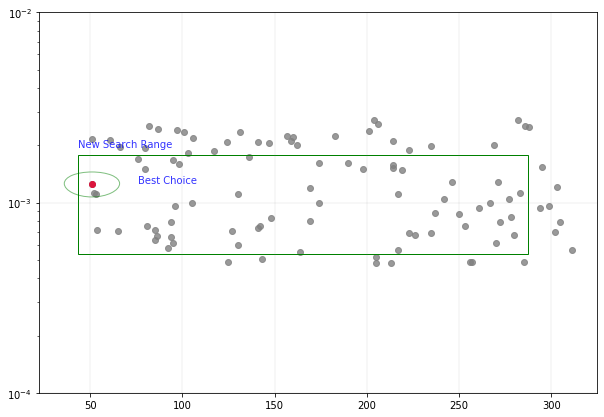

In [12]:
#Detail Random Search

param1_detail = {"hParam type": "learning_rate" ,
          "hParam range": lr_rng_detail }
    
param2_detail = {"hParam type": "minibatch_size",
          "hParam range": mbs_rng_detail } 

#use sample_size >=100 for better tuning

lr_rng_fine, mbs_rng_fine, best_comb = random_search_2D(param1 = param1_detail, param2 = param2_detail , search_type ="detail", evaluate_metric = "accuracy", sample_size = 100, search_summary = True, search_visualization = True)


In [13]:
hyper_params = {"tuned_learning_rate":best_comb[1],
               "tuned_minibatch_size":best_comb[2]}
print(hyper_params)

{'tuned_learning_rate': 0.0012587932934366127, 'tuned_minibatch_size': 51}


In [14]:
save_model(file_name = "tunedHyperParameters2", model = hyper_params)

In [15]:
loaded_hyper_params = load_model(file_name = "tunedHyperParameters2")
print(loaded_hyper_params)

{'tuned_learning_rate': 0.0012587932934366127, 'tuned_minibatch_size': 51}


In [16]:
for key,value in loaded_hyper_params.items():
    print(key + ": " + str(value))

tuned_learning_rate: 0.0012587932934366127
tuned_minibatch_size: 51
